In [3]:
! pip install tabulate

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [54]:
from OurTrainingTools import *

def test_model(madminermodel, test_input_sm, test_input_bsm, bsmparval, epochs, e, n_meas, pm, verbose_t=True, verbose_period_t=1e5, title=''):
        
        def compute_t(madminermodel, nev, counter, test_input):
            n_gen = 0
            while n_gen == 0:
                n_gen = np.random.poisson(nev)
            
            if (counter + n_gen) >= len(test_input):
                return 0., -1
            
            points = test_input[int(counter): int(counter+n_gen)]
            #print('counter = %d, counter+n_gen = %d'%(counter, counter+n_gen))
            #ratio = (madminermodel.evaluate_log_likelihood_ratio(points.cpu().numpy(), 
            #                                np.array([0.]))[0][0])
            if not bsmparval:
                log_ratio = (madminermodel.evaluate_log_likelihood_ratio(points.numpy(), 
                                                np.array([0.]))[0][0])
            else:
                log_ratio = (madminermodel.evaluate_log_likelihood_ratio(points.numpy(), 
                                             np.array([0.]), np.array([bsmparval,]))[0][0])
            print(log_ratio)
            log_ratio = torch.tensor(log_ratio)
            #ratio = 1./ratio
            log_ratio = log_ratio
            out  = 2 * (NBSM - NSM - (log_ratio+torch.log(torch.tensor(NBSM/NSM))).sum(0))
            return out, int(counter+n_gen)
        
        test_start = time.time()
        if verbose_t:
            print("NSM = %.3f --- NBSM = %.3f"%(NSM, NBSM))
        tsm  = torch.empty(n_meas)
        tbsm = torch.empty(n_meas)
        
        tsmcount  = torch.zeros(n_meas+1)
        tbsmcount = torch.zeros(n_meas+1)
            
        for i in range(n_meas):
            tsm[i], tsmcount[i+1] = compute_t(madminermodel, NSM, tsmcount[i], 
                                       test_input_sm)
            tbsm[i], tbsmcount[i+1] = compute_t(madminermodel, NBSM, tbsmcount[i], 
                                       test_input_bsm)
            
            if (tsmcount[i+1] < 0) or (tbsmcount[i+1] < 0):
                print('Reaching the end of test data. Stop tests at %d. '%i)
                tsm, tbsm = tsm[: i], tbsm[: i]
                n_meas = i
                break
                
            if i % (verbose_period_t) == 0:
                print('test %s: tsm = %.3f,  tbsm = %.3f'%(
                        str(i).ljust(4), tsm[i], tbsm[i]))
        
        test_duration = time.time() - test_start
        
        mu_sm     = tsm.mean().item()
        mu_bsm    = tbsm.mean().item()
        sigma_sm  = tsm.std().item()
        sigma_bsm = tbsm.std().item()
        med_sm    = tsm.median().item()
        
        sep    = (mu_sm - mu_bsm)/sigma_bsm
        p      = 1.*len([i for i in tbsm if i > med_sm])/len(tsm) 
        #print(len([i for i in tbsm if i>med_sm]))
        delta1 = (p * (1 - p)/n_meas)**0.5
        delta2 = (sigma_sm/sigma_bsm) * np.exp(-((mu_bsm - mu_sm)**2)/(
                2 * sigma_bsm**2))/(2*(n_meas**0.5))
        print('===> delta1 = %.3f, delta2 = %.3f'%(delta1, delta2))
        deltap = (delta1**2 + delta2**2)**0.5
        
        if verbose_t:
            print('p = %.3f +/- %.3f' %(p, deltap))
            print('Separation = %.2f sigmas'%(sep))
            training_properties = '/toydata/madminer-carl-'+title
            plot_histogram(tsm, tbsm, int(NSM), int(NBSM), p, deltap, sep, epochs, e, 
                                training_properties, results_path)
            print('Partial test after %d epochs (took %.2f seconds)\n'
                          %(e, test_duration))
            
        
        return tsm, tbsm, NSM, NBSM

In [55]:
def plot_histogram(tsm, tbsm, nsm, nbsm, p, deltap, sep, epochs, 
                   e, training_properties, results_folder):
    mint = torch.min(torch.cat((tsm, tbsm))).item()
    maxt = torch.max(torch.cat((tsm, tbsm))).item()
    
    # for some reason the code complains if i don't detach the variables 
    # from their grad-on versions
    tsm, tbsm = tsm.detach(), tbsm.detach()
    
    bins = np.linspace(mint, maxt, 60)
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    plt.hist(tsm,  bins, alpha=0.5, label='SM')
    plt.hist(tbsm, bins, alpha=0.5, label='BSM')
    plt.legend(loc='upper right')
    
    sn   = 'nsm = %s \nnbsm = %s'%(str(nsm), str(nbsm))
    sp   = 'p      '+'= '+ ('%.3f +/- %.3f'%(p, deltap))
    ssep = 'sep   ' + '= ' + ('%.3f'%(sep))
    
    plt.text(x=0.05, y=0.85, transform=ax.transAxes, 
         s=sn+'\n'+sp+'\n'+ssep, bbox=dict(facecolor='blue', alpha=0.2))
    plt.xlabel('t')
    plt.ylabel('p(t)')
    if epochs == e:
        plt.title('Final test\n' + training_properties)
        filename = results_folder + training_properties \
                    + ' histogram.pdf'
        plt.savefig(filename)
        return 
    plt.title(training_properties)
    plt.show()
    
    return

In [56]:
from madminer import ParameterizedRatioEstimator
from madminer.ml.morphing_aware import MorphingAwareRatioEstimator

estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

# Out Sample Test Data
New 2D format, all out of sample

### 1000 big batch

In [57]:
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl1000-bigbatch')

NSM = 2225.504 --- NBSM = 2841.340
[-0.0580593  -0.05370611 -0.16395181 ...  0.43543673 -0.10585171
 -0.21681619]
[-0.00037923 -0.18029624 -0.17668626 ...  0.35912699 -0.22174907
  0.11194429]
test 0   : tsm = 420.377,  tbsm = -333.420
[ 0.001576   -0.12736493 -0.01553163 ... -0.1812324   0.10618736
 -0.180017  ]
[-0.030155   -0.07818913  0.17700136 ... -0.09379643  0.5959857
 -0.10937887]
[-0.19474632 -0.16850054 -0.02868247 ... -0.13775015 -0.07805789
 -0.05256245]
[-0.01746798 -0.29384565 -0.05870992 ... -0.06605238  0.04542404
 -0.04485881]
[ 0.09981329 -0.01512015 -0.10345256 ... -0.12495777 -0.26501107
 -0.21971315]
[-0.21855628 -0.18220454  0.08123181 ... -0.29762483  0.04049733
  0.04676688]
[-0.06449032 -0.06214535 -0.14314136 ... -0.07452977 -0.08876091
 -0.08482683]
[-0.1700331  -0.14441055 -0.23938459 ...  1.3469218  -0.29382485
 -0.07481474]
[-0.10392642 -0.0553124  -0.12650073 ... -0.24818736  0.00694982
 -0.07386041]
[-0.06224841 -0.06108034 -0.09459245 ... -0.22628397  

[-0.15698516 -0.14003587 -0.02509795 ... -0.00415356 -0.09213787
  0.19682708]
[-0.17693675 -0.17637148  0.31838655 ... -0.14335752 -0.08990043
 -0.19924754]
[ 0.11802964 -0.11286223 -0.12405264 ... -0.02094269 -0.08203757
 -0.02260166]
[-0.14931834  2.549442   -0.14060086 ...  0.01280644 -0.1775164
 -0.0502423 ]
[-0.28838164 -0.31544548 -0.12180477 ... -0.09578323  0.52814037
 -0.08630377]
[-0.06773281 -0.18826622 -0.1269263  ... -0.04370058 -0.18459558
 -0.12983966]
[-0.06725439 -0.08477813 -0.10614014 ... -0.05180591 -0.12205887
 -0.11588237]
[-0.09291303 -0.06256366  0.13694727 ... -0.3113991  -0.10219163
 -0.14019597]
[-0.12155795 -0.1978733  -0.09519812 ... -0.17278928  0.96457136
  0.0220872 ]
[-0.07083476 -0.21581358 -0.07198077 ... -0.06465617 -0.11955994
 -0.10910559]
[-0.13339001 -0.09149551 -0.04187047 ... -0.05915254 -0.12197655
 -0.22561866]
[-0.22442377 -0.31677443 -0.02772418 ... -0.10118842 -0.07113713
  0.31406844]
[-0.17602909 -0.09369338  0.12822147 ...  0.20416307 

[ 0.46212947 -0.0722627  -0.0494754  ... -0.18595114  0.7852295
 -0.04335664]
[ 0.17940134 -0.20741671 -0.09029472 ... -0.23667765 -0.08208799
 -0.1485666 ]
[ 0.27022928 -0.15210819  0.8986976  ... -0.01465783 -0.04631257
 -0.14772505]
[-0.05816168 -0.03683454 -0.0925197  ...  0.1440204  -0.06789458
 -0.08518684]
[ 0.49311006 -0.12761325 -0.14414865 ... -0.06862414 -0.10125333
 -0.02919547]
[ 0.01267502 -0.05530244 -0.21508187 ...  0.32937652 -0.10276878
 -0.08266589]
[ 0.21362996 -0.18552071  0.68679017 ... -0.02550346  0.04621434
 -0.20366865]
[-0.01456097 -0.12135482 -0.06859398 ... -0.04834651 -0.12729639
 -0.24533927]
[ 0.5060567  -0.14114995  0.10435259 ... -0.26355165  0.03470463
 -0.14727867]
[ 0.01641622 -0.14449084 -0.11585507 ... -0.13554835 -0.14405948
 -0.12367541]
[-0.23574793 -0.20695013  0.04810354 ...  0.72116303 -0.17250323
 -0.18431568]
[-0.08483601 -0.06476358 -0.08966833 ... -0.12690085 -0.18853462
 -0.09488079]
[-0.13636643  0.07034135 -0.05769569 ...  0.02234775 

[-0.19956386  0.00224957  0.36882776 ... -0.09963483 -0.14184248
 -0.15251681]
[-0.08559769  0.14246318 -0.20660585 ... -0.01493999 -0.11757338
 -0.02138376]
[ 0.16134576 -0.18057466 -0.09138191 ... -0.11296082 -0.13420773
 -0.09036291]
[-0.1201818  -0.07182002 -0.21786624 ... -0.1281249  -0.1986664
  0.06723666]
[-0.05580819 -0.3678018  -0.1658485  ...  3.215652   -0.17226344
 -0.17983651]
[-0.16137516 -0.11108959 -0.02681804 ...  0.05574492  0.0383358
 -0.08894122]
[-0.12629694  0.13460478 -0.02095659 ...  0.04391966 -0.22504699
  0.03305522]
[-0.0647313  -0.1658237  -0.08243489 ... -0.18057144 -0.283859
 -0.03659889]
[-0.14412773 -0.16261595 -0.19461745 ... -0.1684143  -0.0872438
 -0.2339673 ]
[-0.04095811 -0.17057699  0.05834829 ... -0.21338141 -0.09144503
 -0.01921809]
[-0.06596661 -0.053461   -0.02126231 ... -0.14344847 -0.07941505
 -0.17074779]
[-0.09333253 -0.1079123   0.02133608 ... -0.07559931 -0.04250446
  0.00310028]
[-0.13862503 -0.10752764  2.325708   ...  1.0058969  -0.0

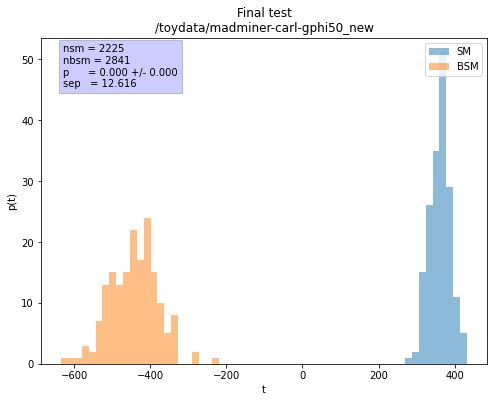

In [58]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], gphival, 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 362.744,  tbsm = -342.334
Reaching the end of test data. Stop tests at 176. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 13.48 sigmas
Partial test after 1 epochs (took 35.94 seconds)



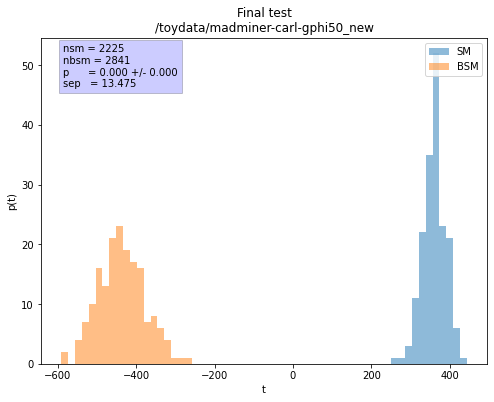

In [8]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2693.988
test 0   : tsm = 285.402,  tbsm = -269.151
Reaching the end of test data. Stop tests at 185. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 10.97 sigmas
Partial test after 1 epochs (took 36.54 seconds)



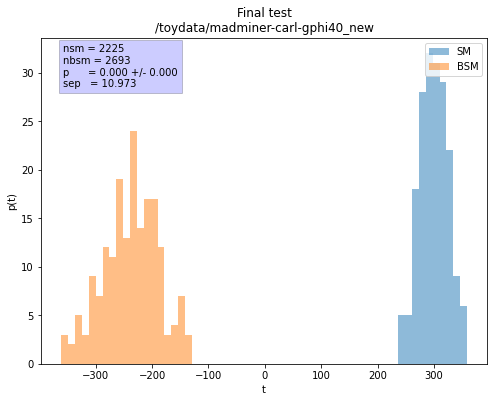

In [9]:
gphival = 40
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2558.585
test 0   : tsm = 268.881,  tbsm = -85.966
Reaching the end of test data. Stop tests at 195. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 8.00 sigmas
Partial test after 1 epochs (took 37.46 seconds)



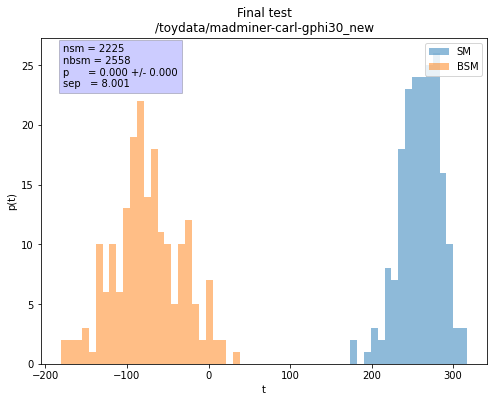

In [10]:
gphival = 30
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2436.280
test 0   : tsm = 271.199,  tbsm = 50.356
Reaching the end of test data. Stop tests at 205. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 5.54 sigmas
Partial test after 1 epochs (took 38.19 seconds)



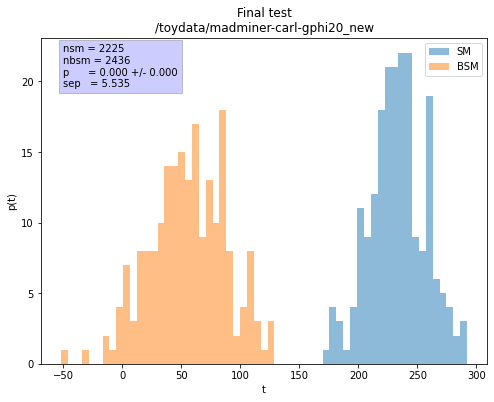

In [11]:
gphival = 20
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2325.162
test 0   : tsm = 253.322,  tbsm = 156.010
Reaching the end of test data. Stop tests at 215. 
===> delta1 = 0.005, delta2 = 0.001
p = 0.005 +/- 0.005
Separation = 2.64 sigmas
Partial test after 1 epochs (took 39.20 seconds)



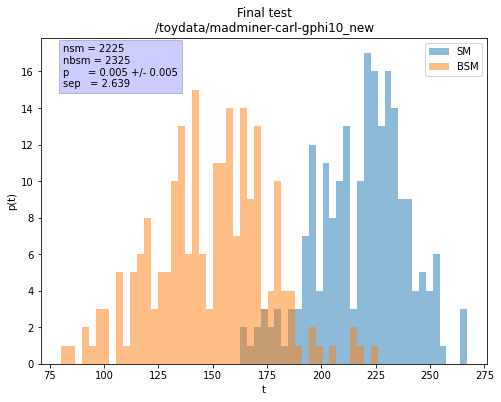

In [12]:
gphival = 10
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = 221.184,  tbsm = 164.740
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.022, delta2 = 0.015
p = 0.119 +/- 0.026
Separation = 1.17 sigmas
Partial test after 1 epochs (took 39.52 seconds)



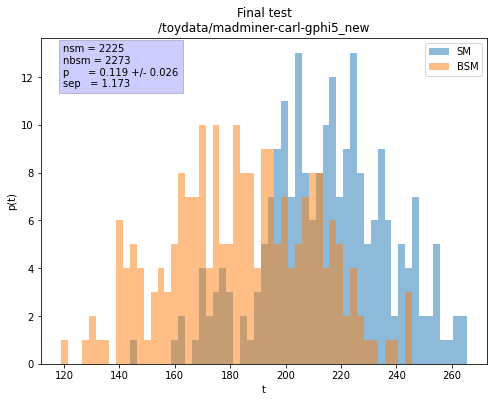

In [13]:
gphival = 5
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

### 50 epochs with big batch

In [28]:
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl50-bigbatch')

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 789.035,  tbsm = 62.971
Reaching the end of test data. Stop tests at 176. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 12.72 sigmas
Partial test after 1 epochs (took 35.63 seconds)



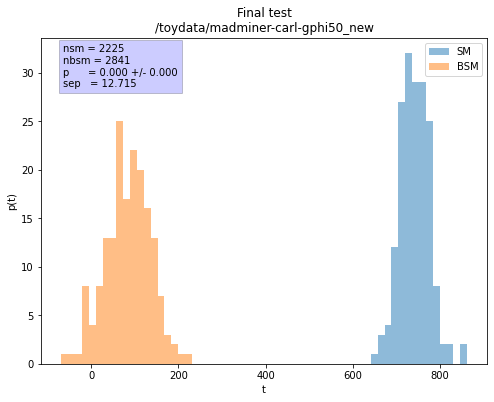

In [29]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2693.988
test 0   : tsm = 692.769,  tbsm = 258.345
Reaching the end of test data. Stop tests at 185. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 9.15 sigmas
Partial test after 1 epochs (took 29.44 seconds)



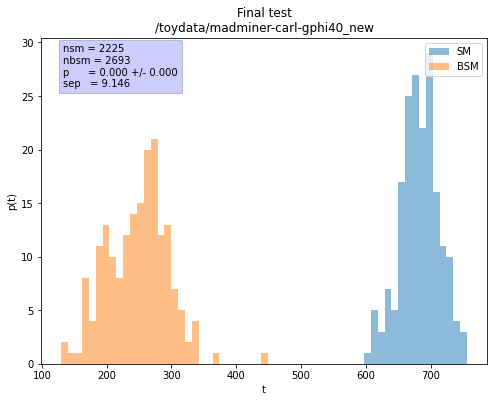

In [30]:
gphival = 40
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2558.585
test 0   : tsm = 645.021,  tbsm = 401.723
Reaching the end of test data. Stop tests at 195. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 6.25 sigmas
Partial test after 1 epochs (took 37.33 seconds)



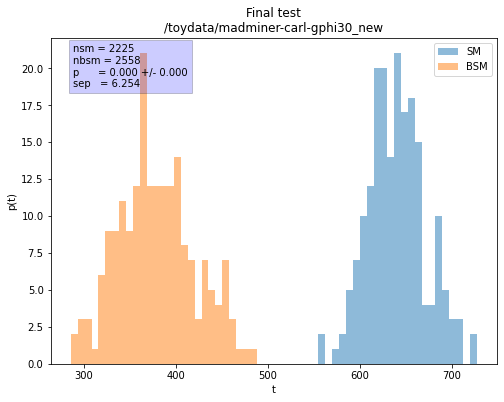

In [31]:
gphival = 30
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2436.280
test 0   : tsm = 568.602,  tbsm = 503.420
Reaching the end of test data. Stop tests at 205. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 3.46 sigmas
Partial test after 1 epochs (took 38.43 seconds)



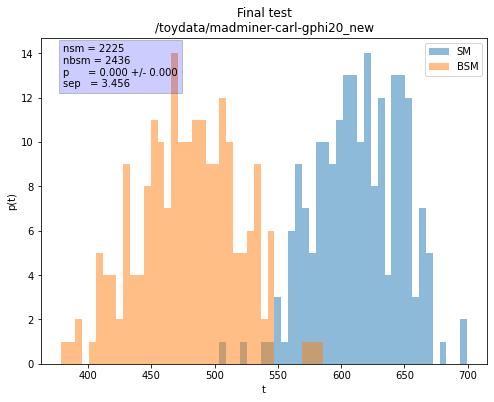

In [32]:
gphival = 20
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2325.162
test 0   : tsm = 594.538,  tbsm = 515.925
Reaching the end of test data. Stop tests at 215. 
===> delta1 = 0.018, delta2 = 0.010
p = 0.079 +/- 0.021
Separation = 1.51 sigmas
Partial test after 1 epochs (took 39.64 seconds)



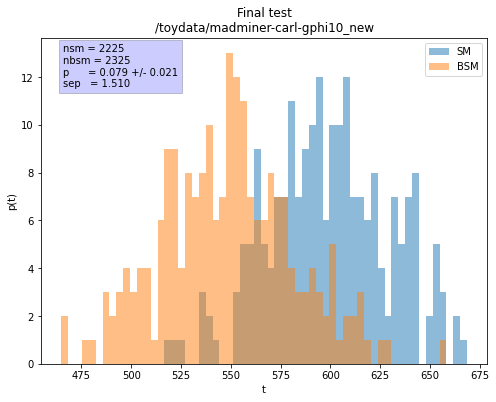

In [33]:
gphival = 10
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = 649.943,  tbsm = 589.049
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.030, delta2 = 0.025
p = 0.273 +/- 0.039
Separation = 0.61 sigmas
Partial test after 1 epochs (took 39.92 seconds)



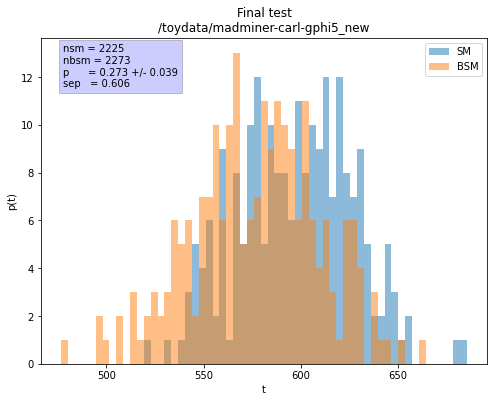

In [34]:
gphival = 5
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

### 10 big batch

In [14]:
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl10-bigbatch')

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 229.027,  tbsm = -209.903
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 13.98 sigmas
Partial test after 1 epochs (took 35.61 seconds)



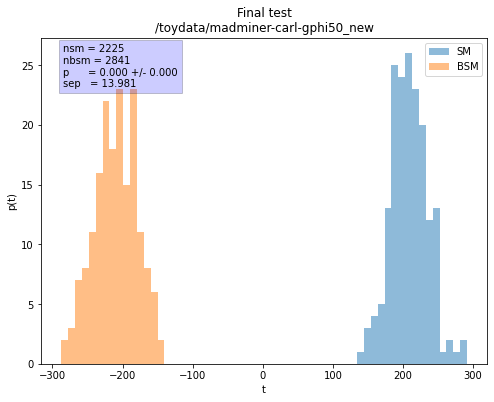

In [15]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2693.988
test 0   : tsm = 139.657,  tbsm = -102.440
Reaching the end of test data. Stop tests at 185. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 9.57 sigmas
Partial test after 1 epochs (took 36.51 seconds)



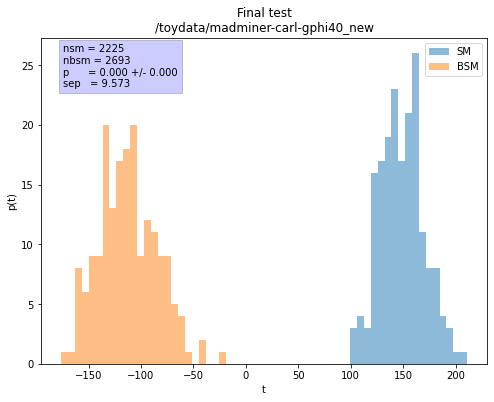

In [16]:
gphival = 40
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2558.585
test 0   : tsm = 141.964,  tbsm = -22.255
Reaching the end of test data. Stop tests at 195. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 6.71 sigmas
Partial test after 1 epochs (took 37.36 seconds)



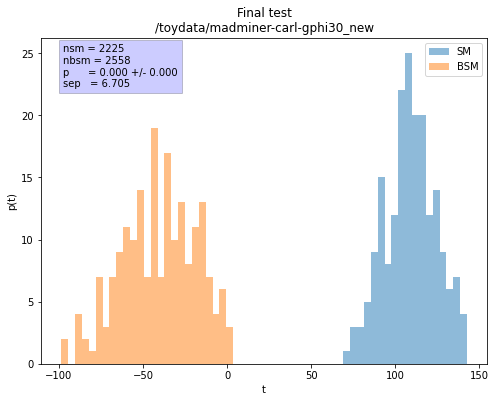

In [17]:
gphival = 30
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2436.280
test 0   : tsm = 72.966,  tbsm = 30.460
Reaching the end of test data. Stop tests at 205. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 4.07 sigmas
Partial test after 1 epochs (took 38.40 seconds)



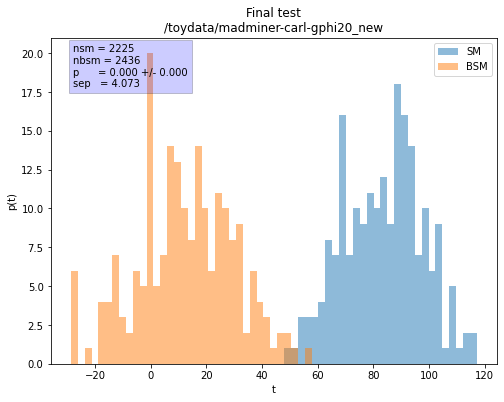

In [18]:
gphival = 20
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2325.162
test 0   : tsm = 81.252,  tbsm = 43.032
Reaching the end of test data. Stop tests at 214. 
===> delta1 = 0.009, delta2 = 0.005
p = 0.019 +/- 0.011
Separation = 1.91 sigmas
Partial test after 1 epochs (took 38.94 seconds)



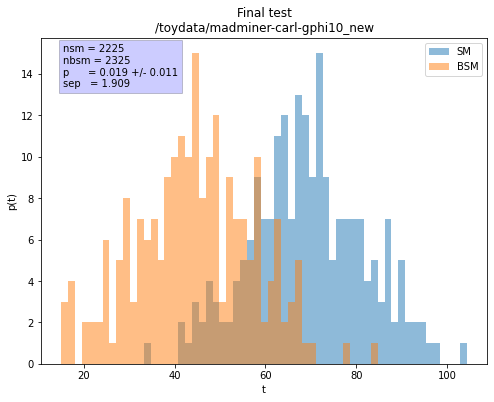

In [19]:
gphival = 10
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = 59.320,  tbsm = 73.057
Reaching the end of test data. Stop tests at 220. 
===> delta1 = 0.026, delta2 = 0.023
p = 0.182 +/- 0.035
Separation = 0.81 sigmas
Partial test after 1 epochs (took 39.95 seconds)



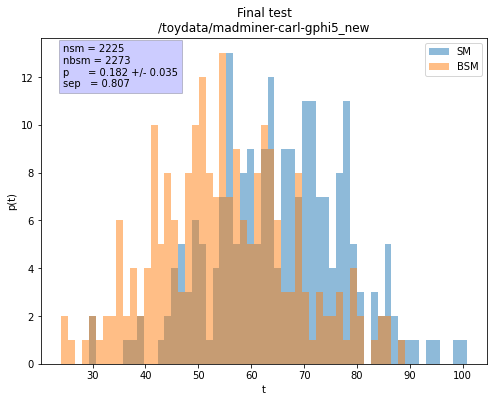

In [20]:
gphival = 5
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

### 1000 default batch

In [21]:
estimator = MorphingAwareRatioEstimator(
    morphing_setup_filename=os.getcwd()+'/data/setup.h5',
    n_hidden=(60,60),
    activation="tanh",
)

estimator.load(os.getcwd()+'/models/carl')

NSM = 2225.504 --- NBSM = 2841.340
test 0   : tsm = 375.341,  tbsm = -766.655
Reaching the end of test data. Stop tests at 175. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 9.52 sigmas
Partial test after 1 epochs (took 35.53 seconds)



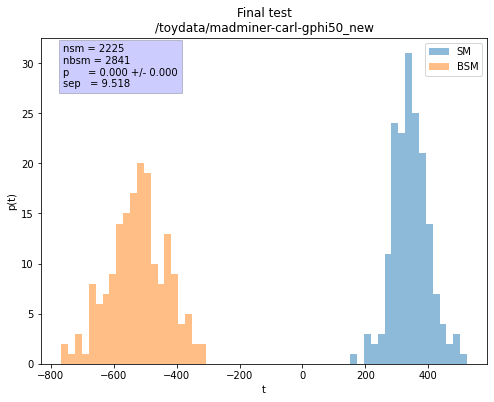

In [22]:
gphival = 50
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2693.988
test 0   : tsm = 209.790,  tbsm = -395.010
Reaching the end of test data. Stop tests at 185. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 6.97 sigmas
Partial test after 1 epochs (took 36.61 seconds)



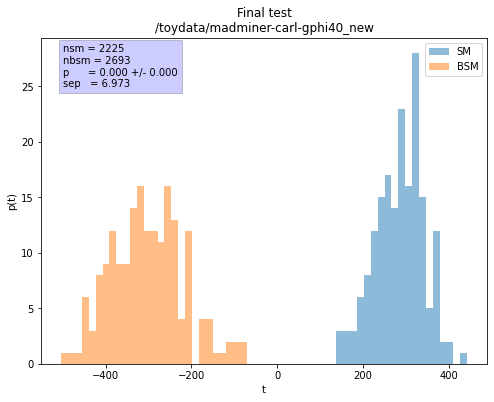

In [23]:
gphival = 40
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2558.585
test 0   : tsm = 261.937,  tbsm = -172.302
Reaching the end of test data. Stop tests at 195. 
===> delta1 = 0.000, delta2 = 0.000
p = 0.000 +/- 0.000
Separation = 4.94 sigmas
Partial test after 1 epochs (took 37.19 seconds)



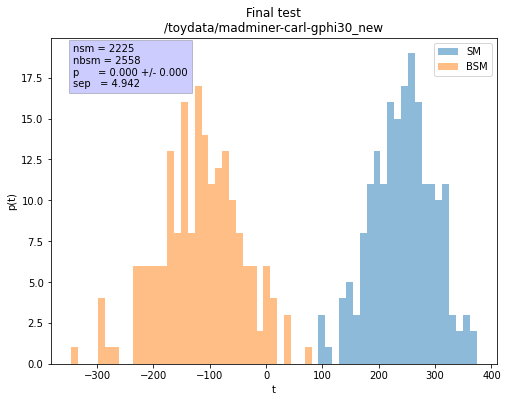

In [24]:
gphival = 30
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2436.280
test 0   : tsm = 163.723,  tbsm = -5.391
Reaching the end of test data. Stop tests at 205. 
===> delta1 = 0.005, delta2 = 0.000
p = 0.005 +/- 0.005
Separation = 2.99 sigmas
Partial test after 1 epochs (took 38.35 seconds)



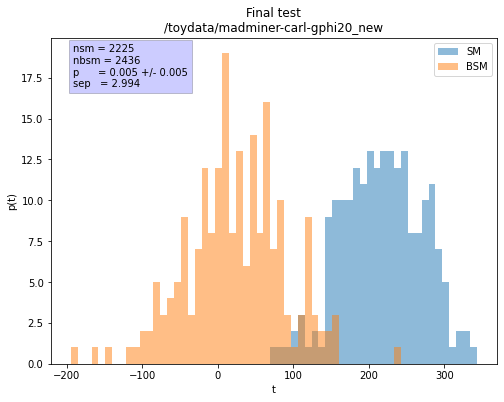

In [25]:
gphival = 20
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2325.162
test 0   : tsm = 119.495,  tbsm = 196.631
Reaching the end of test data. Stop tests at 214. 
===> delta1 = 0.023, delta2 = 0.016
p = 0.136 +/- 0.028
Separation = 1.16 sigmas
Partial test after 1 epochs (took 38.88 seconds)



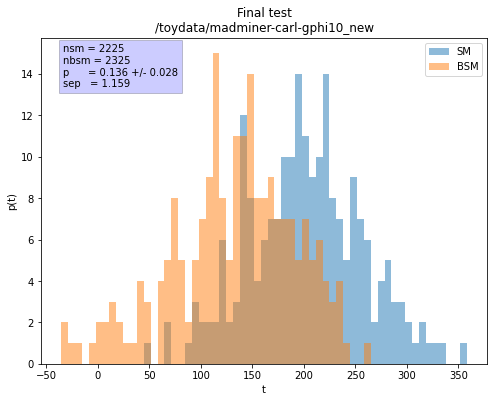

In [26]:
gphival = 10
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()

NSM = 2225.504 --- NBSM = 2273.448
test 0   : tsm = 230.866,  tbsm = 149.098
Reaching the end of test data. Stop tests at 219. 
===> delta1 = 0.031, delta2 = 0.027
p = 0.315 +/- 0.042
Separation = 0.46 sigmas
Partial test after 1 epochs (took 39.24 seconds)



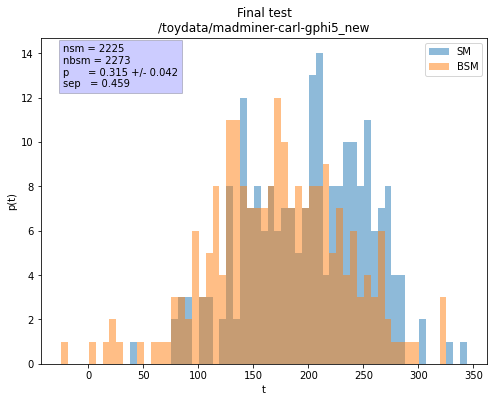

In [27]:
gphival = 5
f = h5py.File(os.getcwd()+'/toydata/gphi_toydata_test_%d_out.h5'%(gphival), 'r')
Data = np.array(f['Data'])
Labels = np.array(f['Labels'])
NSM = np.array(f['NSM'])
NBSMList = np.array(f['NBSMList'])
NBSM = NBSMList[0]

n_epochs = int(1e4)
results_path = os.getcwd()

Idx_test = torch.randperm(len(Data))
Data_test = torch.Tensor(Data[Idx_test])
Label_test = torch.Tensor(Labels[Idx_test])


test_model(estimator, Data_test[Label_test==0, :], Data_test[Label_test==1, :], 1, 1, 4000, 'plus', 
          verbose_t=True, verbose_period_t=1e5, title='gphi%d_new'%(gphival))

f.close()